In [1]:
# Note: This notebook requires tensorboard and anytree libraries to run install with:
# pip install tensorboard
# pio install anytree

In [19]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch import nn
import torch.nn.functional as F
from anytree import Node, RenderTree

def get_backward_graph(node,id=0,parent=None):
    if(parent is None):
        node = node.grad_fn
        tree_node = Node(f"{node.name()}:{id}") 
    else:
        tree_node = Node(f"{node.name()}:{id}",parent=parent)
    for i, new_node in enumerate(node.next_functions):
        if(new_node[0] is not None):
            get_backward_graph(new_node[0],id=i,parent=tree_node)
    return(tree_node)

## Define a basic function

In [20]:
x1 = torch.tensor(0.50,requires_grad=True)
x2 = torch.tensor(0.75,requires_grad=True)

def fun(x1,x2):
    a = x2*x1
    y1 = torch.log(a)
    y2 = torch.sin(x2)
    return y1*y2

w=fun(x1,x2) 

## Display the forward compute graph and autodiff graph (drawn manually) for this function
Reference: https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/

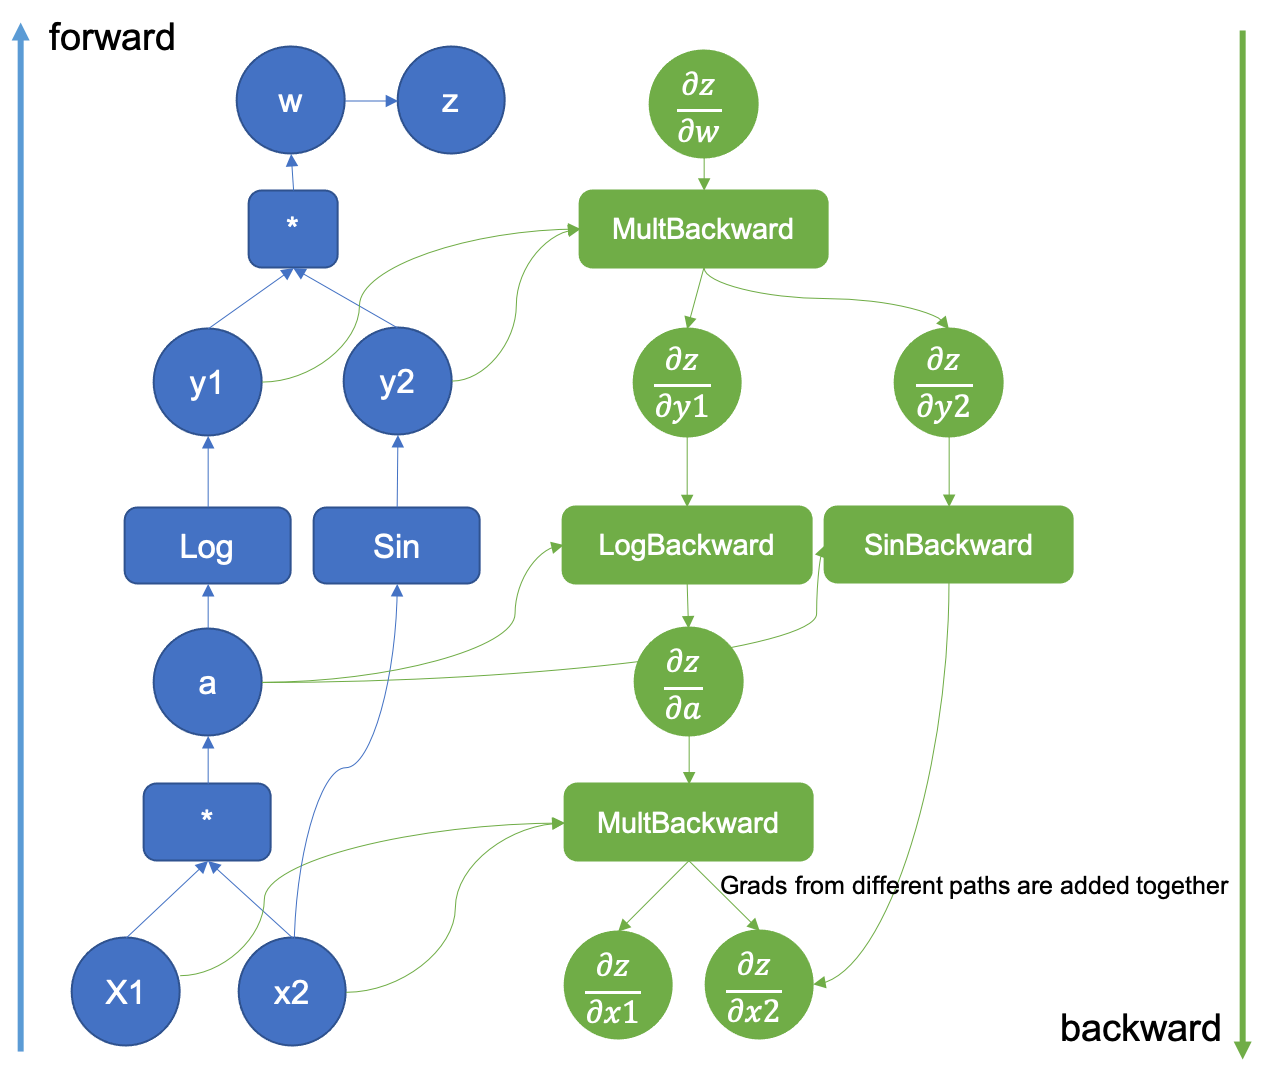

## Use jit.trace to extract and show the forward compute graph

In [21]:
trace = torch.jit.trace(fun, (x1,x2))
g=str(trace.graph)
for n in g.split("\n"):
    print(n.split("#")[0])

graph(%x1 : Float(requires_grad=1, device=cpu),
      %x2 : Float(requires_grad=1, device=cpu)):
  %a : Float(requires_grad=1, device=cpu) = aten::mul(%x2, %x1) 
  %y1 : Float(requires_grad=1, device=cpu) = aten::log(%a) 
  %y2 : Float(requires_grad=1, device=cpu) = aten::sin(%x2) 
  %5 : Float(requires_grad=1, device=cpu) = aten::mul(%y1, %y2) 
  return (%5)



## Wrap the function in a module and display with tensorboard

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

    def forward(self, x1,x2):
        w=fun(x1,x2)
        return w

model = Model()

writer = SummaryWriter('runs/autodiff')
dummy_input = torch.randn(1, 10)  
writer.add_graph(model, (x1,x2))
writer.close()

## Extract and display the autodiff graph

In [24]:
w=fun(x1,x2) 
tree = get_backward_graph(w)
for pre, _, node in RenderTree(tree):
    print(f"{pre}{node.name}")

MulBackward0:0
├── LogBackward0:0
│   └── MulBackward0:0
│       ├── torch::autograd::AccumulateGrad:0
│       └── torch::autograd::AccumulateGrad:1
└── SinBackward0:1
    └── torch::autograd::AccumulateGrad:0


## Run the bakward pass

In [25]:
x1 = torch.tensor(0.50,requires_grad=True)
x2 = torch.tensor(0.75,requires_grad=True)

def fun(x1,x2):
    a = x2*x1
    y1 = torch.log(a)
    y2 = torch.sin(x2)
    return y1*y2

w=fun(x1,x2) 
w.backward()
print("Autodiff:", x1.grad, x2.grad)
with torch.no_grad():
    print("Manual:", torch.sin(x2)/x1, torch.sin(x2)/x2 + torch.log(x1*x2)*torch.cos(x2))

Autodiff: tensor(1.3633) tensor(0.1912)
Manual: tensor(1.3633) tensor(0.1912)


## Modify the function with data-dependent control flow
Note: Torch has the ability to differentiate a computation with data dependent control flow. The forward and backward functions apply to what ever path through the control flow is active for the provided inputs. The jit.trace function will also extract the forward compute graph for what ever path through the control flow is active for the provided inputs. Note that this functionality allows you to compute "gradients" of discontinuous and non-differnetiable functions, which may then cause problems with down-stream optimization processes.

In [26]:
def fun(x1,x2):
    a = x2*x1
    y1 = torch.log(a)
    y2 = torch.sin(x2)
    if(y2>0):    
        return y1*y2
    else:
        return y1+y2

In [31]:
#Define arguments
x1 = torch.tensor(0.50,requires_grad=True)
x2 = torch.tensor(0.75,requires_grad=True)

#Produce the trace
#Note the final computation uses y1+y2
trace = torch.jit.trace(fun, (x1,x2))
g=str(trace.graph)
for n in g.split("\n"):
    print(n.split("#")[0])

#Run forward
w  = fun(x1,x2)

#Produce the backward graph
tree = get_backward_graph(w)
for pre, _, node in RenderTree(tree):
    print(f"{pre}{node.name}")
print("")

#Run backward
w.backward()
print("Autodiff:", x1.grad, x2.grad,"\n")

graph(%x1 : Float(requires_grad=1, device=cpu),
      %x2 : Float(requires_grad=1, device=cpu)):
  %a : Float(requires_grad=1, device=cpu) = aten::mul(%x2, %x1) 
  %y1 : Float(requires_grad=1, device=cpu) = aten::log(%a) 
  %y2 : Float(requires_grad=1, device=cpu) = aten::sin(%x2) 
  %7 : Float(requires_grad=1, device=cpu) = aten::mul(%y1, %y2) 
  return (%7)

MulBackward0:0
├── LogBackward0:0
│   └── MulBackward0:0
│       ├── torch::autograd::AccumulateGrad:0
│       └── torch::autograd::AccumulateGrad:1
└── SinBackward0:1
    └── torch::autograd::AccumulateGrad:0

Autodiff: tensor(1.3633) tensor(0.1912) 



/var/folders/4l/8sylm17d22b0xn1df89_v14c0000gt/T/ipykernel_26495/1220098461.py:5: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if(y2>0):


In [30]:
#Define arguments
x1 = torch.tensor(0.50,requires_grad=True)
x2 = torch.tensor(-1.0,requires_grad=True)

#Produce the trace
#Note the final computation uses y1+y2
trace = torch.jit.trace(fun, (x1,x2))
g=str(trace.graph)
for n in g.split("\n"):
    print(n.split("#")[0])

#Run forward
w  = fun(x1,x2)

#Produce the backward graph
tree = get_backward_graph(w)
for pre, _, node in RenderTree(tree):
    print(f"{pre}{node.name}")
print("")

#Run backward
w.backward()
print("Autodiff:", x1.grad, x2.grad,"\n")


graph(%x1 : Float(requires_grad=1, device=cpu),
      %x2 : Float(requires_grad=1, device=cpu)):
  %a : Float(requires_grad=1, device=cpu) = aten::mul(%x2, %x1) 
  %y1 : Float(requires_grad=1, device=cpu) = aten::log(%a) 
  %y2 : Float(requires_grad=1, device=cpu) = aten::sin(%x2) 
  %7 : int = prim::Constant[value=1]() 
  %8 : Float(requires_grad=1, device=cpu) = aten::add(%y1, %y2, %7) 
  return (%8)

AddBackward0:0
├── LogBackward0:0
│   └── MulBackward0:0
│       ├── torch::autograd::AccumulateGrad:0
│       └── torch::autograd::AccumulateGrad:1
└── SinBackward0:1
    └── torch::autograd::AccumulateGrad:0

Autodiff: tensor(2.) tensor(-0.4597) 



/var/folders/4l/8sylm17d22b0xn1df89_v14c0000gt/T/ipykernel_26495/1220098461.py:5: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if(y2>0):
